# Goal
So the excellent [original kernel](https://www.kaggle.com/gaborvecsei/basic-pure-computer-vision-segmentation-lb-0-229) put together by [Gabor](https://www.kaggle.com/gaborvecsei) gets 0.229 "without even using the training data" which is a great result, but what if we use the training data.  
## Overview
The idea is to take the parameters found in the original kernel and try to improve them using the IOU score as the ground criteria.
1. Get a cross-validation setup working that gives us a similar value to the 0.229
1. Rewrite the threshold and label methods to take all of their parameters
1. Use scipy.optimize (probably sk-optimize would be better, but we'll keep it simple here) to improve the values
1. Predict and submit

In [2]:
from os.path import join
import cv2
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from glob import glob
import os
from skimage.io import imread
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
dsb_data_dir = os.path.join('..', 'input')
stage_label = 'stage1'

In [3]:
all_images = glob(os.path.join(dsb_data_dir, 'stage1_*', '*', '*', '*'))
img_df = pd.DataFrame({'path': all_images})
img_id = lambda in_path: in_path.split('/')[-3]
img_type = lambda in_path: in_path.split('/')[-2]
img_group = lambda in_path: in_path.split('/')[-4].split('_')[1]
img_stage = lambda in_path: in_path.split('/')[-4].split('_')[0]
img_df['ImageId'] = img_df['path'].map(img_id)
img_df['ImageType'] = img_df['path'].map(img_type)
img_df['TrainingSplit'] = img_df['path'].map(img_group)
img_df['Stage'] = img_df['path'].map(img_stage)
img_df.sample(2)

,path,ImageId,ImageType,TrainingSplit,Stage
5759,../input/stage1_train/08275a5b1c2dfcd739e8c488...,08275a5b1c2dfcd739e8c4888a5ee2d29f83eccfa75185...,masks,train,stage1
29524,../input/stage1_train/64eeef16fdc4e26523d27bfa...,64eeef16fdc4e26523d27bfa71a1d38d2cb2e4fa116c0d...,masks,train,stage1


# Process and Import Training Data
Here we load in the training data images and labels. We load the label images into a single index colored integer image.

In [4]:
%%time
train_df = img_df.query('TrainingSplit=="train"')
train_rows = []
group_cols = ['Stage', 'ImageId']
for n_group, n_rows in train_df.groupby(group_cols):
    c_row = {col_name: col_value for col_name, col_value in zip(group_cols, n_group)}
    c_row['masks'] = n_rows.query('ImageType == "masks"')['path'].values.tolist()
    c_row['images'] = n_rows.query('ImageType == "images"')['path'].values.tolist()
    train_rows += [c_row]
train_img_df = pd.DataFrame(train_rows)    
IMG_CHANNELS = 3
def read_and_stack(in_img_list):
    return np.sum(np.stack([i*(imread(c_img)>0) for i, c_img in enumerate(in_img_list, 1)], 0), 0)

def read_hist_bw(in_img_list):
    return cv2.imread(in_img_list[0], cv2.IMREAD_GRAYSCALE)
train_img_df['images'] = train_img_df['images'].map(read_hist_bw)
train_img_df['masks'] = train_img_df['masks'].map(read_and_stack).map(lambda x: x.astype(int))
train_img_df.sample(1)

CPU times: user 45 s, sys: 22.8 s, total: 1min 7s
Wall time: 1min 12s


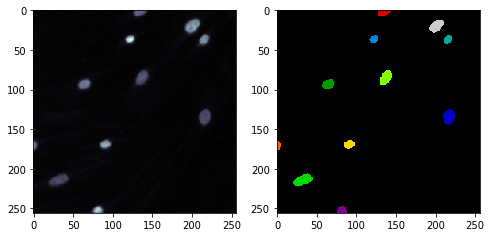

In [5]:
for _, c_row in train_img_df.sample(1).iterrows():
    fig, (ax1, ax2) = plt.subplots(1,2, figsize = (8, 4))
    ax1.imshow(c_row['images'], cmap = 'bone')
    ax2.imshow(c_row['masks'], cmap = 'nipy_spectral')

In [6]:
from sklearn.model_selection import train_test_split
train_split_df, valid_split_df = train_test_split(train_img_df, 
                                                  test_size = 0.4, 
                                                  random_state = 2018,
                                                  # ensures both splits have the different sized images
                                                  stratify = train_img_df['images'].map(lambda x: '{}'.format(np.shape))
                                                 )
print('train', train_split_df.shape, 'valid', valid_split_df.shape)


train (402, 4) valid (268, 4)


Here are the two functions from the original kernel

In [7]:
def gabor_threshold(image_gray):
    image_gray = cv2.GaussianBlur(image_gray, (7, 7), 1)
    ret, thresh = cv2.threshold(image_gray, 0, 255, cv2.THRESH_OTSU)
    
    _, cnts, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
    max_cnt_area = cv2.contourArea(cnts[0])
    
    if max_cnt_area > 50000:
        ret, thresh = cv2.threshold(image_gray, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)
    
    return thresh

def gabor_apply_morphology(thresh):
    mask = cv2.dilate(thresh, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5)))
    mask = cv2.erode(mask, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5)))
    return mask

def gabor_pipeline(in_img):
    thresh = gabor_threshold(in_img)
    return gabor_apply_morphology(thresh)

> # IOU Metric
[This kernel](https://www.kaggle.com/aglotero/another-iou-metric) has a nice IOU implementation that we just copy here

In [8]:
from skimage.morphology import label
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = label(y_pred_in > 0.5)
    
    true_objects = len(np.unique(labels))
    pred_objects = len(np.unique(y_pred))

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

# Wrap Everything Up
We have a single function to evaluate the IOU of a model on a dataset

In [9]:
def calculate_iou(in_df, thresh_func):
    pred_masks = valid_split_df['images'].map(thresh_func).values
    gt_masks = valid_split_df['masks'].values
    all_ious = [iou_metric(cur_gt, cur_pred, print_table=False) for cur_gt, cur_pred in 
            zip(gt_masks, pred_masks)]
    return np.mean(all_ious)

# Estimate our IOU with the Gabor Model
Here we see the result is 0.35 which is quite a bit higher than the actual 0.229, so we have to be aware the value isn't super reliable.

In [10]:
%%time
print('IOU', calculate_iou(valid_split_df, gabor_pipeline))

IOU 0.358980348487
CPU times: user 3.41 s, sys: 20 ms, total: 3.43 s
Wall time: 3.4 s


# Define a Parametric Model
Here we take the basic Gabor pipeline and allow the important parameters to be adjusted so they can consequently be optimized

In [14]:
def parametric_pipeline(image_gray, 
                       blur_sigma = 1, 
                        dilate_iters = 1,
                       dilate_size = 5, 
                       erode_size = 5):
    # some functions don't like floats
    blur_sigma = np.clip(blur_sigma, 0.01, 100)
    blur_size = int(2*round(3*blur_sigma)+1)
    dilate_size = int(dilate_size)
    erode_size = int(erode_size)
    dilate_iters = int(dilate_iters)
    if blur_size>0:
        image_gray = cv2.GaussianBlur(image_gray, (blur_size, blur_size), blur_sigma)
    
    ret, thresh = cv2.threshold(image_gray, 0, 255, cv2.THRESH_OTSU)
    _, cnts, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
    max_cnt_area = cv2.contourArea(cnts[0])
    
    if max_cnt_area > 50000:
        ret, thresh = cv2.threshold(image_gray, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)
    mask = thresh
    for i in range(dilate_iters):
        if dilate_size>0:
            mask = cv2.dilate(mask, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (dilate_size, dilate_size)))
        if erode_size>0:
            mask = cv2.erode(mask, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (erode_size, erode_size)))
    return mask

# Optimization
A very simple optimization routine with no knowledge about morphology, integer steps, iterations or anything else. It just serves as an example of how such a pipeline can be optimized. At the very least some random search would probably improve the results

In [15]:
from scipy.optimize import fmin
from tqdm import tqdm
base_x0_min = [0, 0, 0, 0]
base_x0_max = [10, 10, 15, 15]

def random_search_fmin(random_restart = 5, search_steps = 5):
    results = []
    base_x0 = (1, 1, 5, 5) # starting point
    for _ in tqdm(range(random_restart)):
        def inv_iou_func(scale_x0):
            x0 = [s*x/10 for s,x in zip(scale_x0, base_x0)]
            # score it on the training data
            try:
                score = calculate_iou(train_split_df, 
                                      lambda x: parametric_pipeline(x, *x0))
            except Exception as e:
                print('Arguments:', ' '.join(['%1.1f' % xi for xi in x0]))
                raise ValueError(e)
            print('Arguments:', ' '.join(['%1.1f' % xi for xi in x0]), 
                  'IOU: %2.3f' % score)
            return 1-score # since we are minimizing the result

        opt_scalars = fmin(inv_iou_func, 
                          (10, 10, 10, 10), 
                           xtol = 0.1,
                          maxiter = search_steps)
        
        opt_params = [s*x/10 for s,x in zip(opt_scalars, base_x0)]
        results += [(calculate_iou(train_split_df, 
                                  lambda x: parametric_pipeline(x, *opt_params)), 
                     opt_params)]
        # pick a new random spot to iterate from
        base_x0 = [np.random.choice(np.linspace(x_start, x_end, 10))
                   for x_start, x_end in zip(base_x0_min, base_x0_max)]
    n_out = sorted(results, key = lambda x: 1-x[0])
    return n_out[0][1], n_out


In [16]:
%%time
opt_params, results = random_search_fmin(5, 8)

  0%|          | 0/5 [00:00<?, ?it/s]

Arguments: 1.0 1.0 5.0 5.0 IOU: 0.359
Arguments: 1.1 1.0 5.0 5.0 IOU: 0.359
Arguments: 1.0 1.1 5.0 5.0 IOU: 0.359
Arguments: 1.0 1.0 5.2 5.0 IOU: 0.359
Arguments: 1.0 1.0 5.0 5.2 IOU: 0.359
Arguments: 0.9 1.0 5.1 5.1 IOU: 0.361
Arguments: 0.9 1.0 5.2 5.2 IOU: 0.361
Arguments: 0.9 1.0 5.2 4.8 IOU: 0.348
Arguments: 1.0 1.0 5.1 5.1 IOU: 0.360
Arguments: 0.9 1.0 4.9 5.2 IOU: 0.320
Arguments: 1.0 1.0 5.2 5.0 IOU: 0.359
Arguments: 0.9 1.0 5.2 5.2 IOU: 0.388
Arguments: 0.9 0.9 5.3 5.3 IOU: 0.390
Arguments: 0.9 1.0 5.3 5.3 IOU: 0.362
Arguments: 0.9 1.0 5.3 5.4 IOU: 0.391
Arguments: 0.8 1.0 5.4 5.6 IOU: 0.391
Arguments: 0.8 1.0 5.5 5.5 IOU: 0.391


 20%|██        | 1/5 [00:55<03:42, 55.65s/it]

Arguments: 2.2 5.6 3.3 15.0 IOU: 0.000
Arguments: 2.3 5.6 3.3 15.0 IOU: 0.000
Arguments: 2.2 5.8 3.3 15.0 IOU: 0.000
Arguments: 2.2 5.6 3.5 15.0 IOU: 0.000
Arguments: 2.2 5.6 3.3 15.8 IOU: 0.000
Arguments: 2.3 5.7 3.4 14.2 IOU: 0.000
Arguments: 2.2 5.6 3.4 15.4 IOU: 0.000
Arguments: 2.3 5.6 3.3 15.0 IOU: 0.000
Arguments: 2.2 5.7 3.3 15.0 IOU: 0.000
Arguments: 2.2 5.6 3.4 15.0 IOU: 0.000
Arguments: 2.2 5.6 3.3 15.4 IOU: 0.000
Arguments: 2.2 5.6 3.4 14.6 IOU: 0.000
Arguments: 2.2 5.6 3.3 15.2 IOU: 0.000
Arguments: 2.2 5.6 3.3 15.0 IOU: 0.000
Arguments: 2.2 5.6 3.3 15.0 IOU: 0.000
Arguments: 2.2 5.6 3.4 15.0 IOU: 0.000
Arguments: 2.2 5.6 3.3 15.2 IOU: 0.000
Arguments: 2.2 5.6 3.4 14.8 IOU: 0.000
Arguments: 2.2 5.6 3.3 15.1 IOU: 0.000
Arguments: 2.2 5.6 3.3 15.0 IOU: 0.000
Arguments: 2.2 5.6 3.3 15.0 IOU: 0.000
Arguments: 2.2 5.6 3.4 15.0 IOU: 0.000
Arguments: 2.2 5.6 3.3 15.1 IOU: 0.000
Optimization terminated successfully.
         Current function value: 1.000000
         Iterations: 4


 40%|████      | 2/5 [02:34<03:51, 77.11s/it]

Arguments: 5.6 10.0 11.7 15.0 IOU: 0.000
Arguments: 5.8 10.0 11.7 15.0 IOU: 0.000
Arguments: 5.6 10.5 11.7 15.0 IOU: 0.000
Arguments: 5.6 10.0 12.3 15.0 IOU: 0.000
Arguments: 5.6 10.0 11.7 15.8 IOU: 0.000
Arguments: 5.7 10.2 12.0 14.2 IOU: 0.000
Arguments: 5.8 9.6 12.1 14.6 IOU: 0.001
Arguments: 5.9 9.2 12.3 14.4 IOU: 0.001
Arguments: 5.9 9.7 12.4 14.3 IOU: 0.001
Arguments: 6.1 9.6 12.8 14.0 IOU: 0.001
Arguments: 5.7 9.6 12.8 14.0 IOU: 0.001
Arguments: 5.6 9.4 13.4 13.5 IOU: 0.114
Arguments: 5.8 8.9 13.2 14.4 IOU: 0.003
Arguments: 6.0 8.6 13.4 13.4 IOU: 0.105
Arguments: 5.8 9.1 13.9 13.4 IOU: 0.111


 60%|██████    | 3/5 [04:14<02:49, 84.75s/it]

Arguments: 0.0 4.4 5.0 8.3 IOU: 0.003
Arguments: 0.0 4.4 5.0 8.3 IOU: 0.003
Arguments: 0.0 4.7 5.0 8.3 IOU: 0.003
Arguments: 0.0 4.4 5.2 8.3 IOU: 0.003
Arguments: 0.0 4.4 5.0 8.8 IOU: 0.003
Arguments: 0.0 4.6 5.1 7.9 IOU: 0.046
Arguments: 0.0 4.6 5.2 7.5 IOU: 0.046
Arguments: 0.0 4.6 4.8 8.1 IOU: 0.001
Arguments: 0.0 4.5 5.1 8.3 IOU: 0.003
Arguments: 0.0 4.5 5.1 8.1 IOU: 0.003
Arguments: 0.0 4.5 5.1 8.1 IOU: 0.003
Arguments: 0.0 4.6 5.1 8.1 IOU: 0.003
Arguments: 0.0 4.5 5.2 8.1 IOU: 0.003
Arguments: 0.0 4.6 5.0 8.0 IOU: 0.001
Arguments: 0.0 4.5 5.1 8.1 IOU: 0.003
Arguments: 0.0 4.5 5.1 8.0 IOU: 0.003
Arguments: 0.0 4.5 5.1 8.0 IOU: 0.003
Arguments: 0.0 4.6 5.1 8.0 IOU: 0.003
Arguments: 0.0 4.5 5.2 8.0 IOU: 0.003
Arguments: 0.0 4.6 5.0 8.0 IOU: 0.046
Arguments: 0.0 4.5 5.1 7.9 IOU: 0.046
Arguments: 0.0 4.6 5.1 7.9 IOU: 0.046
Arguments: 0.0 4.6 5.1 7.8 IOU: 0.046
Arguments: 0.0 4.6 5.1 7.9 IOU: 0.046


 80%|████████  | 4/5 [05:38<01:24, 84.52s/it]

Arguments: 1.1 1.1 10.0 13.3 IOU: 0.187
Arguments: 1.2 1.1 10.0 13.3 IOU: 0.187
Arguments: 1.1 1.2 10.0 13.3 IOU: 0.187
Arguments: 1.1 1.1 10.5 13.3 IOU: 0.187
Arguments: 1.1 1.1 10.0 14.0 IOU: 0.089
Arguments: 1.1 1.1 10.2 12.7 IOU: 0.201
Arguments: 1.2 1.2 10.4 12.0 IOU: 0.201
Arguments: 1.2 1.2 9.7 12.7 IOU: 0.122
Arguments: 1.1 1.1 10.3 13.2 IOU: 0.186
Arguments: 1.2 1.1 10.2 12.7 IOU: 0.202
Arguments: 1.1 1.1 10.2 12.7 IOU: 0.201
Arguments: 1.1 1.2 10.2 12.7 IOU: 0.201
Arguments: 1.1 1.1 10.4 12.7 IOU: 0.201
Arguments: 1.2 1.2 10.0 12.3 IOU: 0.202
Arguments: 1.2 1.1 10.2 12.2 IOU: 0.202
Arguments: 1.2 1.1 10.2 11.9 IOU: 0.285
Arguments: 1.2 1.1 10.2 11.8 IOU: 0.285
Arguments: 1.2 1.1 9.9 12.4 IOU: 0.122
Arguments: 1.2 1.1 10.3 12.1 IOU: 0.202
Arguments: 1.2 1.1 10.1 12.3 IOU: 0.203


100%|██████████| 5/5 [06:47<00:00, 81.49s/it]

CPU times: user 6min 52s, sys: 1.7 s, total: 6min 54s
Wall time: 6min 47s


# Calculate the Score on Hold-Out (validation)
Here we calculate the score on the validation to see if we actually improved anything

In [17]:
print('IOU', calculate_iou(valid_split_df, 
                           lambda x: parametric_pipeline(x, *opt_params)))

IOU 0.391259674129


Now we load the test images and apply the algorithm to them

In [18]:
%%time
test_df = img_df.query('TrainingSplit=="test"')
test_rows = []
group_cols = ['Stage', 'ImageId']
for n_group, n_rows in test_df.groupby(group_cols):
    c_row = {col_name: col_value for col_name, col_value in zip(group_cols, n_group)}
    c_row['images'] = n_rows.query('ImageType == "images"')['path'].values.tolist()
    test_rows += [c_row]
test_img_df = pd.DataFrame(test_rows)    

test_img_df['images'] = test_img_df['images'].map(read_hist_bw)
print(test_img_df.shape[0], 'images to process')
test_img_df.sample(1)

65 images to process
CPU times: user 316 ms, sys: 8 ms, total: 324 ms
Wall time: 360 ms


In [19]:
%%time
test_img_df['masks'] = test_img_df['images'].map(lambda x: 
                                                 parametric_pipeline(x, *opt_params))

CPU times: user 80 ms, sys: 8 ms, total: 88 ms
Wall time: 70.2 ms


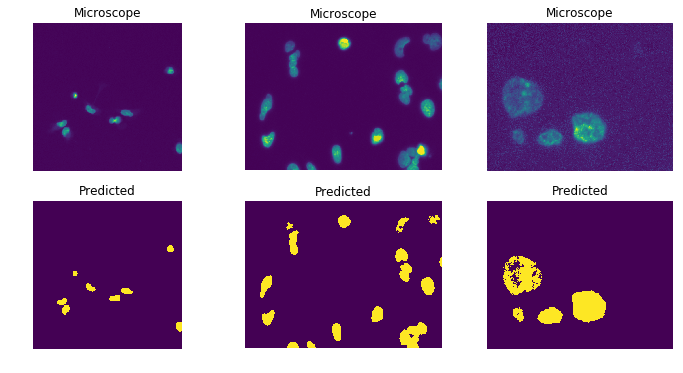

In [20]:
n_img = 3
fig, m_axs = plt.subplots(2, n_img, figsize = (12, 6))
for (_, d_row), (c_im, c_lab) in zip(test_img_df.sample(n_img).iterrows(), 
                                     m_axs.T):
    c_im.imshow(d_row['images'])
    c_im.axis('off')
    c_im.set_title('Microscope')
    
    c_lab.imshow(d_row['masks'])
    c_lab.axis('off')
    c_lab.set_title('Predicted')

In [21]:
def rle_encoding(x):
    '''
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = np.where(x.T.flatten()==1)[0] # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cut_off = 0.5):
    lab_img = label(x>cut_off)
    if lab_img.max()<1:
        lab_img[0,0] = 1 # ensure at least one prediction per image
    for i in range(1, lab_img.max()+1):
        yield rle_encoding(lab_img==i)

In [22]:
test_img_df['rles'] = test_img_df['masks'].map(lambda x: list(prob_to_rles(x)))

In [23]:
out_pred_list = []
for _, c_row in test_img_df.iterrows():
    for c_rle in c_row['rles']:
        out_pred_list+=[dict(ImageId=c_row['ImageId'], 
                             EncodedPixels = ' '.join(np.array(c_rle).astype(str)))]
out_pred_df = pd.DataFrame(out_pred_list)
print(out_pred_df.shape[0], 'regions found for', test_img_df.shape[0], 'images')
out_pred_df.sample(3)

2712 regions found for 65 images


,EncodedPixels,ImageId
689,114427 7 114944 12 115462 15 115981 17 116500 ...,432f367a4c5b5674de2e2977744d10289a064e5704b21a...
2141,56069 3 56593 4 57117 6 57641 7 58165 8 58689 ...,c8e79ff4ac55f4b772057de28e539727b7f4f2a3de73bf...
496,213200 3 213710 7 214221 11 214734 10 215247 1...,259b35151d4a7a5ffdd7ab7f171b142db8cfe40beeee67...


In [24]:
out_pred_df[['ImageId', 'EncodedPixels']].to_csv('predictions.csv', index = False)